In [13]:
import pickle 

import numpy as np 

from utils import sort_and_filter_metrics, CHECKPOINT_STEPS

from transformers import AutoConfig

### Correlation between SVD and CKA Scores 

Note that the hypothesis is that the weights that converge faster in a larger matrix are those that are more
full rank.

First analysis we want to run if how the singular values correlate with the CKA scores. 

Note:
1. we can then conduct the same analysis with the grad svd weights;
2. we can also do this analysis on a per-head layer basis

In [14]:
model_size = "70m"

model_config = AutoConfig.from_pretrained(f"EleutherAI/pythia-{model_size}-deduped")

In [8]:
with open(f'/home/rd654/pretraining-playground/computed_statistics/{model_size}/weight_svd_per_layer.pkl', 'rb') as f:
    _svd_weights = pickle.load(f)

    sing_values_weights__mlp = sort_and_filter_metrics(_svd_weights, "dense_4h_to_h", remove_heads=True)
    sing_values_weights__ov = sort_and_filter_metrics(_svd_weights, "ov_circuit", remove_heads=True)

In [9]:
model_size = "70m"
with open(f"/home/rd654/pretraining-playground/computed_statistics/{model_size}/cka_scores_per_layer.pkl", "rb") as f:
    _cka_activations = pickle.load(f)
    cka_activations__mlp = sort_and_filter_metrics(_cka_activations, "dense_4h_to_h", remove_heads=True)
    cka_activations__ov = sort_and_filter_metrics(_cka_activations, "ov_circuit", remove_heads=True)

In [17]:
def compute_explained_variance(S):
    """ For a matrix of singular values, compute the explained variance."""
    variances = S**2 / S.numel()
    explained_variances = variances / np.sum(variances)
    return explained_variances

def compute_condition_number(S, matrix_rank=None):
    """ For a matrix of singular values, compute the condition number."""
    if matrix_rank is None:
        matrix_rank = len(S)
    return S[0] / S[matrix_rank - 1]

In [18]:
mlp_rank = model_config.hidden_size
attention_head_rank = model_config.hidden_size // model_config.num_attention_heads

condition_numbers_per_layer__mlp = {}
for name, singular_values in sing_values_weights__mlp.items():
    condition_numbers_per_layer__mlp[name] = []
    for checkpoint_step, checkpoint_singular_values in zip(CHECKPOINT_STEPS, singular_values):
        S = np.array(checkpoint_singular_values)
        condition_numbers_per_layer__mlp[name].append(compute_condition_number(S, matrix_rank=mlp_rank))

condition_numbers_per_layer__attention = {}
for name, singular_values in sing_values_weights__ov.items():
    condition_numbers_per_layer__attention[name] = []
    for checkpoint_step, checkpoint_singular_values in zip(CHECKPOINT_STEPS, singular_values):
        S = np.array(checkpoint_singular_values)
        condition_numbers_per_layer__attention[name].append(compute_condition_number(S, matrix_rank=attention_head_rank))

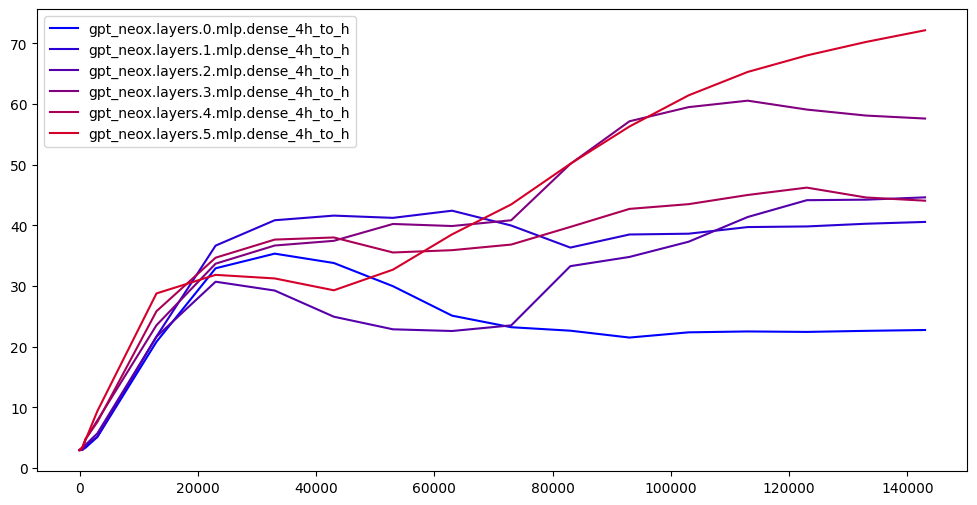

In [19]:
# plot out the condition numbers for each layer across the checkpoint steps 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for i, (name, condition_numbers) in enumerate(condition_numbers_per_layer__mlp.items()):
    color = (i / len(condition_numbers_per_layer__mlp.keys()), 0, 1 - i / len(condition_numbers_per_layer__mlp.keys()))
    plt.plot(CHECKPOINT_STEPS, condition_numbers, label=name, color=color)

plt.legend()

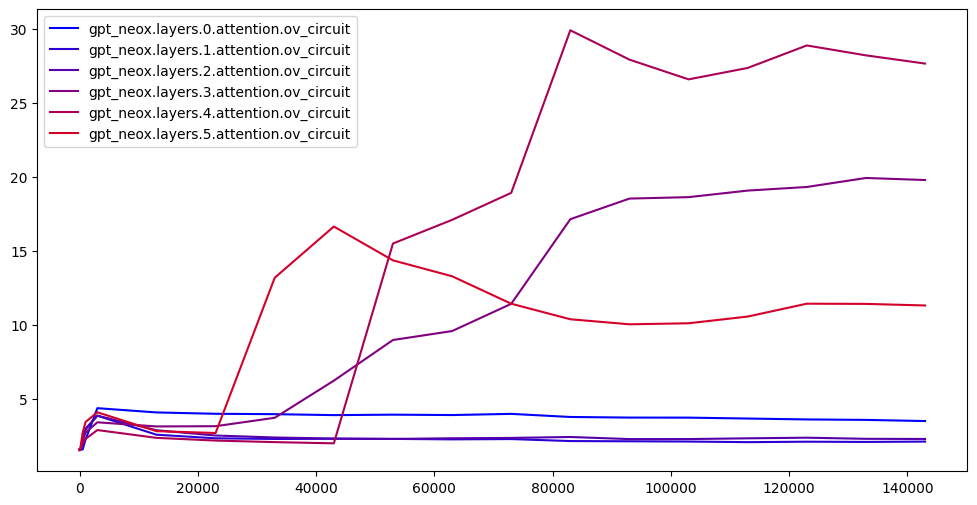

In [20]:
plt.figure(figsize=(12, 6))
for i, (name, condition_numbers) in enumerate(condition_numbers_per_layer__attention.items()):
    color = (i / len(condition_numbers_per_layer__attention.keys()), 0, 1 - i / len(condition_numbers_per_layer__attention.keys()))
    plt.plot(CHECKPOINT_STEPS, condition_numbers, label=name, color=color)

plt.legend()